In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("surgeries to predict.csv", index_col=0)
data.head(5)

,Surgery Type,Anesthesia Type,Age,BMI,DoctorID,AnaesthetistID,Duration in Minutes
0,3,1,44,20,853628,178042,149
1,0,0,56,27,369199,714022,86
2,0,1,45,22,519569,906701,81
3,1,0,63,22,230984,454178,177
4,1,0,40,35,706850,636647,127


In [3]:
data.isnull().sum()

Surgery Type           0
Anesthesia Type        0
Age                    0
BMI                    0
DoctorID               0
AnaesthetistID         0
Duration in Minutes    0
dtype: int64

In [4]:
data.nunique()/len(data)

Surgery Type           0.0005
Anesthesia Type        0.0002
Age                    0.0075
BMI                    0.0038
DoctorID               0.9946
AnaesthetistID         0.9943
Duration in Minutes    0.0217
dtype: float64

We see that neither the DoctorID nor the AnaesthetistID will be useful to us as input b/c we do not have sufficient repeated data to be able to train and subsequently test doctors/anaesthetists specific models.<br>
Therefore, we will disregard these two columns in this exercise.<br>
But we note that for doctors/anaesthetists that do have sufficient samples, it is possible to develop specialized models beyond a generic model.

In [5]:
data.groupby(['Surgery Type','Anesthesia Type'])['Duration in Minutes'].count()

Surgery Type  Anesthesia Type
0             0                   999
              1                   999
1             0                  1036
              1                  1005
2             0                   985
              1                   976
3             0                  1029
              1                   981
4             0                  1009
              1                   981
Name: Duration in Minutes, dtype: int64

There is a healthy spread of data between the 10 distinct non-ordinal classes of $Surgery \times Anesthesia$, so we won't need to worry about stratifying our sampling of test data.

In [6]:
data[['Surgery Type','Anesthesia Type']].corrwith(data['Duration in Minutes'], method=stats.pearsonr)

,Surgery Type,Anesthesia Type
0,0.49596,-6.103587e-02
1,0.00000,1.005598e-09


Furthermore, we see that the Surgery Type, on it's own, exhibits a very high point-biserial correlation of 0.5 with near perfect confidence.<br>
This is confirmed by the plot below.

Surgery Type
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
Name: Duration in Minutes, dtype: object

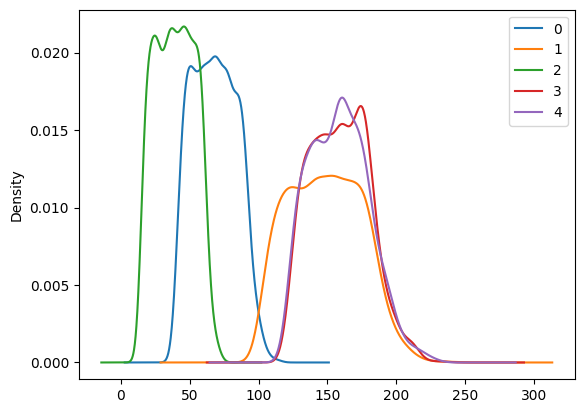

In [7]:
data.groupby(['Surgery Type'])['Duration in Minutes'].plot(kind='kde', legend=True)

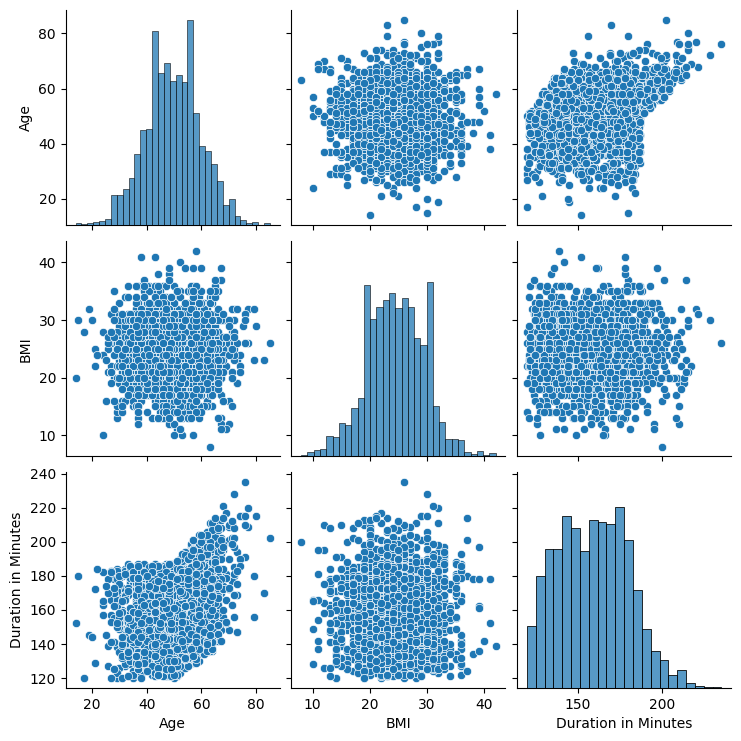

In [8]:
mask = (data['Surgery Type'] == 3) #| True
sns.pairplot(data[mask][['Age','BMI','Duration in Minutes']])

Finally, we see that there is some type of rectified linear relationship between Age and Duration (we show for one class of Surgery Type, but it is the same for all).<br>
Additionally, we notice a centrally distributed sample on Age and BMI, suggesting that we may want to stratify our sample to ensure we capture the edges if we use a non-parametric prediction model.

In [9]:
ordinal_cols = ['Age','BMI','Duration in Minutes']
# The 3 is used so that we can bucket into 3 groups, each - left, center, right
data_groups = data.groupby(['Surgery Type','Anesthesia Type'], group_keys=False).apply(
    lambda x: (x[ordinal_cols] - x[ordinal_cols].mean())/x[ordinal_cols].std()/3
    ).round().astype(int)*3
data['Test Class'] = \
    data[['Surgery Type','Anesthesia Type']].astype('str').agg('.'.join, axis=1) \
    + '.' + data_groups.astype('str').agg('.'.join, axis=1)
data.nunique()

Surgery Type              5
Anesthesia Type           2
Age                      75
BMI                      38
DoctorID               9946
AnaesthetistID         9943
Duration in Minutes     217
Test Class              194
dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

one_item_class = data['Test Class'].isin(
    data.groupby(['Test Class'])['Duration in Minutes'].count()[data.groupby(['Test Class'])['Duration in Minutes'].count() == 1].index)
data.loc[one_item_class,'Test Class'] = 'Singles Class'

train, test = train_test_split(data, test_size=0.2, random_state=0, stratify=data[['Test Class']])
print(f"Train Size: {len(train)}")
print(f"Test Size: {len(test)}")

Train Size: 8000
Test Size: 2000


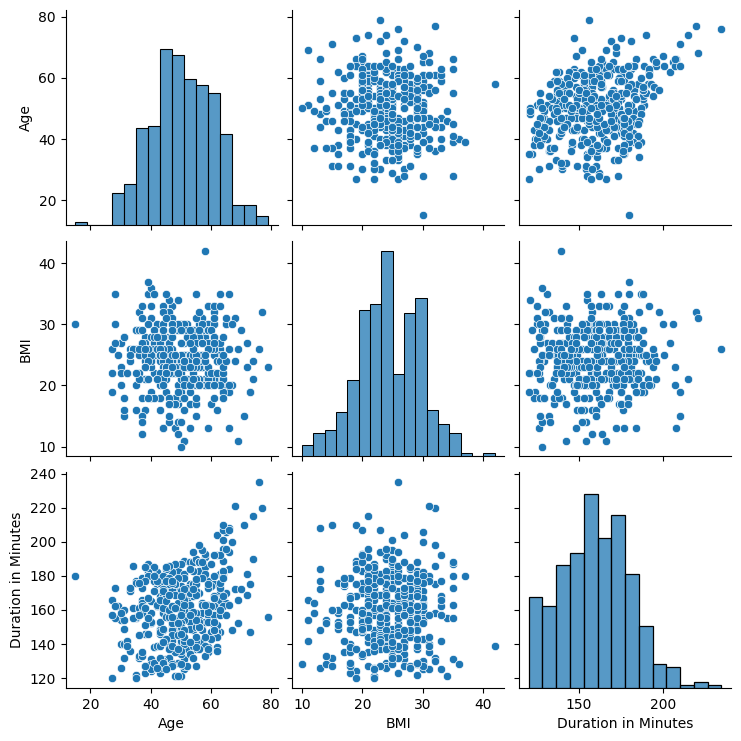

In [11]:
mask = (test['Surgery Type'] == 3) #| True
sns.pairplot(test[mask][['Age','BMI','Duration in Minutes']])

As shown above, we have a nice stratified test sample.<br>
Let's take a lazy approach to test our hypothesis below using a decision tree regression with squared error loss.

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor

trainX, trainY = train[['Surgery Type', 'Age']].values, np.squeeze(train[['Duration in Minutes']].values)
testX, testY = test[['Surgery Type', 'Age']].values, np.squeeze(test[['Duration in Minutes']].values)
est1 = HistGradientBoostingRegressor(categorical_features=[True, False])

est1.fit(trainX, trainY)
print(f"Residual squared errors on our chosen variables: {est1.score(testX, testY)}")

trainX, trainY = train[['Surgery Type', 'Anesthesia Type', 'Age', 'BMI']].values, np.squeeze(train[['Duration in Minutes']].values)
testX, testY = test[['Surgery Type', 'Anesthesia Type', 'Age', 'BMI']].values, np.squeeze(test[['Duration in Minutes']].values)
est2 = HistGradientBoostingRegressor(categorical_features=[True, True, False, False])

est2.fit(trainX, trainY)
print(f"Residual squared errors on all variables: {est2.score(testX, testY)}")

Residual squared errors on our chosen variables: 0.88039105007635
Residual squared errors on all variables: 0.8823183095068446


An $R^2$ of 0.88 versus 0.882 suggests that our hypothesis was correct and the only important features are Surgery Type and Age.<br>
Let's take a look at the "lazy model" predictions w.r.t our data.

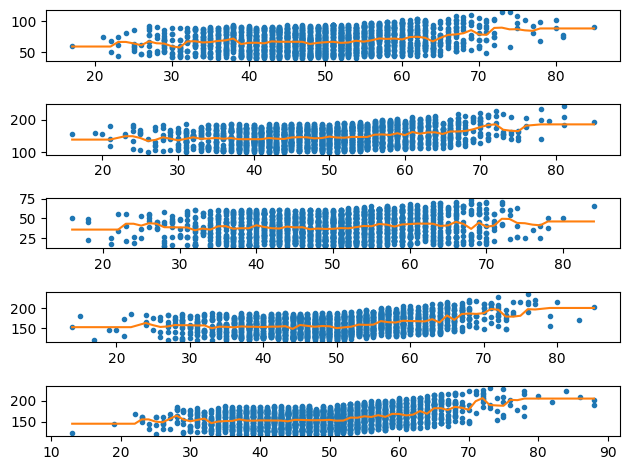

In [13]:
data['Predicted Duration in Minutes'] = est1.predict(data[['Surgery Type', 'Age']].values)

fig, axs = plt.subplots(5)
for i, ax in enumerate(axs):
    mask = (data['Surgery Type'] == i)
    x, yt, yp = data[mask][['Age', 'Duration in Minutes', 'Predicted Duration in Minutes']].sort_values(by='Age').values.T
    ax.plot(x, yt, linestyle='None', marker='.')
    ax.plot(x, yp)
    
fig.tight_layout()

Our non-parametric approach, while achieving a high $R^2$, would probably be a bad choice here, as is.<br>
There is no reason to expect jumps in the prediction as we move along an, essentially, continuous control variable.
We have two options at this point:<br>
1. Use seperate parametric models for each class - e.g. a rectified linear model as suggest earlier.<br>
2. Use some smoothing mechanism to stabilize our predictions.<br>
</p>
Let's explore the second option using a basic MA.

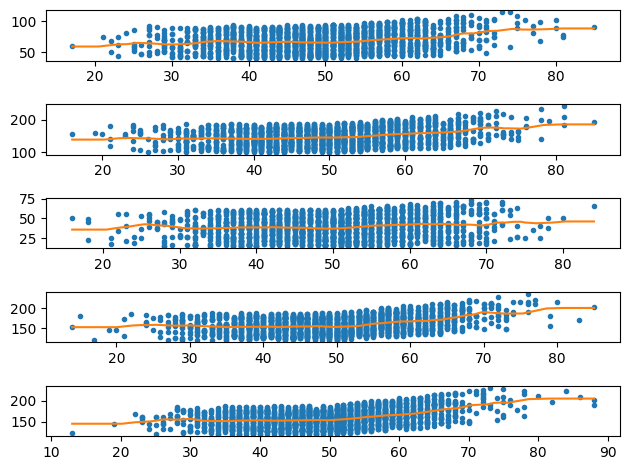

In [14]:
fig, axs = plt.subplots(5)
n = 15 # MA length

for i, ax in enumerate(axs):
    mask = (data['Surgery Type'] == i)
    x, yt = data[mask][['Age', 'Duration in Minutes']].sort_values(by='Age').values.T
    ax.plot(x, yt, linestyle='None', marker='.')

    xp = np.linspace(min(x), max(x), 200)
    yp = est1.predict(np.concatenate([[[i]*len(xp)], [xp]], axis=0).T)

    yp = np.convolve(
        np.pad(yp, (n-n//2, n//2-1), 'constant', constant_values=(yp[0], yp[-1])),
        np.ones(n)/n,
        mode='valid')
    ax.plot(xp, yp)

fig.tight_layout()
